In [13]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
from matplotlib import pyplot as plt

In [2]:
conn = psycopg2.connect(dbname="local_density", user="adi", password="password")

In [3]:
SELECT = """
    SELECT d.client_count, d.dump_time,
           r.id AS group_id, r.name AS group_name,
           b.id AS parent_id, b.name AS building_name
    FROM density_data d
    JOIN routers r ON r.id = d.group_id
    JOIN buildings b ON b.id = r.building_id"""

In [16]:
def db_to_pandas(conn):
    """ Return occupancy data as pandas dataframe
    column dtypes:
        group_id: int64
        group_name: category
        parent_id: int64
        parent_name: category
        client_count: int64
        week: int64
        weekday: int64
        time_point: string
    index: DateTimeIndex -- dump_time
    Parameters
    ----------
    conn: psycopg2.extensions.connection
        Connection to db
    Returns
    -------
    pandas.DataFrame
        Density data in a Dataframe
    """

    df = pd.read_sql(SELECT, conn) \
           .set_index("dump_time") \
           .assign(group_name=lambda df: df["group_name"].astype('category'),
                   parent_id=lambda df: df["parent_id"].astype('category'))
    df['week'] = df.index.weekofyear  # get week of the year (1-52) for a given timestamp
    df['weekday'] = df.index.weekday  # get day of the week (1-7) for a given timestamp
    time_points = zip(df.index.hour, df.index.minute)
    time_points = ["{}:{}".format(x[0], x[1]) for x in time_points]
    df["time_point"] = time_points # get time of the day (HH:mm) for a given timestamp
    
    return df


In [17]:
def parse_by_week(df):
    """Return a dictionary of dataframes where the keys are days of the week
    Parameters
    ----------
    df: pandas.DataFrame
        Density data in a Dataframe
    Returns
    -------
    Dictionary
        a dictionary of dataframes where the keys are days of the week
    """
    weeks = np.unique(df['week'])
    week_dic = dict.fromkeys(weeks)
    
    for week in weeks:
        week_dic[week] = df[df['week'] == week]
    
    return week_dic

In [18]:
def predict_tomorrow(day_dict):
    """Return a dataframes of predicted counts for tomorrow 
    where the indexs are timestamps of the week and columns are locations
    Parameters
    ----------
    day_dict: Dictionary
        a dictionary of dataframes of density data where the keys are days of the week
    Returns
    -------
    pandas.DataFrame
        Dataframe containing predicted counts
    """
    # get time stats for tomorrow
    tomorrow = datetime.datetime.today() + datetime.timedelta(days=1)
    day_of_week = tomorrow.weekday()
    week_of_year = tomorrow.isocalendar()[1]
    
    # find past data for the given day of the week
    past_data = day_dict[week_of_year]
    past_data = past_data[past_data['weekday'] == day_of_week]
    
    results, locs = [], []
    for group in np.unique(past_data["group_name"]):
        locs.append(group)
        group_data = past_data[past_data["group_name"] == group]
        group_data = group_data[["client_count", "time_point"]]
        group_result = group_data.groupby("time_point").mean()  # average counts by time for each location
        results.append(group_result.transpose())
    result = pd.concat(results)  # combine the data for all locations
    result.index = locs
    result = result.transpose()  # make time points indexes and locations columns
    
    old_indexes = result.index
    new_indexes = []

    # make sure all time index has the same string format
    for index in old_indexes:
        splited = index.split(":")
        leading, trailing = splited[0], splited[1]
        if len(leading) == 1:
            leading = "0" + leading
        new_index = leading + ":" + trailing
        new_indexes.append(new_index)

    result.index = new_indexes
    result = result.sort_index()
    
    return result

In [19]:
data = db_to_pandas(conn)

In [24]:
data.columns

Index(['client_count', 'group_id', 'group_name', 'parent_id', 'building_name',
       'week', 'weekday', 'time_point'],
      dtype='object')

In [20]:
by_week = parse_by_week(data)

In [21]:
tp = predict_tomorrow(by_week)

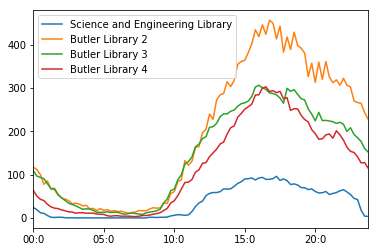

In [15]:
tmp = tp[['Science and Engineering Library', 'Butler Library 2', 'Butler Library 3', 'Butler Library 4']]
tmp.plot()
plt.show()